# Examples for subsetting the GRIP roads dataset.

These examples use the GRIP global roads dataset, in .gdb format, from https://www.globio.info/download-grip-dataset

## Saving the subsetted datasets:
The subsetted dataset can be saved to a new shapefile by specifying an output directory using the ```outfile``` argument, this is omitted for these examples. 

In [1]:
import pymovebank as pmv

import geopandas as gpd
import matplotlib.pyplot as plt 

%matplotlib inline

In [2]:
pmv.datasets.available

['GRIP4_Region1_vector_shp.zip',
 'GRIP4_GlobalRoads.gdb',
 'GRIP4_global_vector_fgdb',
 'GRIP4_Region1_vector_shp',
 'caribou_reference_data.csv',
 'caribou_data.csv',
 'y2y_region_priority_areas_2013.gdb']

In [3]:
# Shapefile of GRIP Region 1 dataset
roadsfile = pmv.get_path("GRIP4_GlobalRoads.gdb")

In [4]:
# To plot subset results
def plot_subset(subset_data, boundary, y2y_border=None, track_points=None):
    fig, ax = plt.subplots()
    boundary.plot(ax=ax, color='c', alpha=0.4)
    subset_data.plot(ax=ax, color='b', linewidth=0.75)
    if y2y_border is not None: 
        y2y_border.plot(ax=ax, color='r', alpha=0.4)
    if track_points is not None: 
        tracks.plot(ax = ax, color = 'r', marker='.', alpha = 0.4)

## Option 1: Subset the roads dataset using bbox 

### Small subset, from .gdb global dataset

If you only need to subset a small area without a large number of features, it will be very fast even though it's subsetting from the entire global dataset:

In [5]:
# Small subset for testing (lat/long bounding box coordinates)
bbox = [-123, 54, -120, 56] 

In [6]:
%%time
roads_subset, boundary = pmv.subset_data(roadsfile, bbox=bbox)

CPU times: user 31.3 ms, sys: 11.5 ms, total: 42.8 ms
Wall time: 76.8 ms


The light blue areas in the plots are showing the boundary that was used to make the subset. By default, the function returns all features that intersect with the bounding box, so the subset includes parts of roads extending past the bounding box:

CPU times: user 120 ms, sys: 10.3 ms, total: 131 ms
Wall time: 61.7 ms


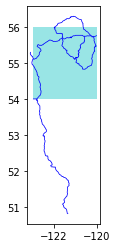

In [7]:
%%time
plot_subset(roads_subset, boundary)

 #### Option to clip features at boundary edge 
 By default, the function returns all features that intersect with the bounding box, but there is also the option to clip the features at the boundary edge:

In [8]:
%%time
# Deleting each subset between examples for speed tests, so there aren't extra things in memory from the previous tests
del roads_subset, boundary   
roads_subset, boundary = pmv.subset_data(roadsfile, bbox=bbox, clip=True)

CPU times: user 58 ms, sys: 11.8 ms, total: 69.7 ms
Wall time: 27.6 ms


CPU times: user 117 ms, sys: 11.2 ms, total: 129 ms
Wall time: 45 ms


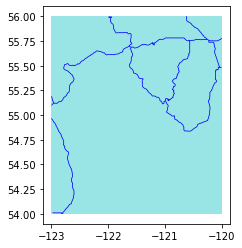

In [9]:
%%time
plot_subset(roads_subset, boundary)

### Larger subset, from .gdb global dataset
The requested subset in this example has over 300,000 records, so it takes longer to process and plot:

In [10]:
# Larger subset for testing 
bbox = [-141, 41, -108, 67] 

In [11]:
%%time
del roads_subset, boundary   
roads_subset, boundary = pmv.subset_data(roadsfile, bbox=bbox)

CPU times: user 10.8 s, sys: 488 ms, total: 11.3 s
Wall time: 11.5 s


In [12]:
len(roads_subset)

307280

CPU times: user 30.6 s, sys: 389 ms, total: 31 s
Wall time: 30.7 s


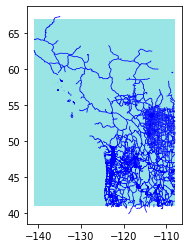

In [13]:
%%time
plot_subset(roads_subset, boundary)

## Option 2: Subsetting the roads dataset using bounding geometry from a file

In this case, subsetting using the Y2Y region boundary. 
The roads dataset and the GIS layer with the Y2Y boundary are in different projections; this is handled. 

In [14]:
y2yfile = pmv.get_path('y2y_region_priority_areas_2013.gdb')

In [15]:
# Reading in the region boundary here, to display it with the examples. 
# For just subsetting, you don't need to read in this file
y2y = gpd.read_file(y2yfile)

CRS of the roads dataset and Y2Y dataset:

In [16]:
pmv.get_crs(roadsfile)

'epsg:4326'

In [17]:
pmv.get_crs(y2yfile)

'PROJCS["WGS_1984_Albers",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["Degree",0.0174532925199433]],PROJECTION["Albers_Conic_Equal_Area"],PARAMETER["latitude_of_center",42],PARAMETER["longitude_of_center",-120],PARAMETER["standard_parallel_1",42],PARAMETER["standard_parallel_2",68],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]'

In [18]:
%%time
del roads_subset, boundary   
roads_subset, boundary = pmv.subset_data(roadsfile, bounding_geom=y2yfile)

CPU times: user 10.5 s, sys: 267 ms, total: 10.7 s
Wall time: 11.1 s


CPU times: user 30.5 s, sys: 411 ms, total: 30.9 s
Wall time: 30.6 s


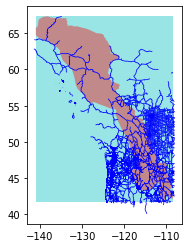

In [19]:
%%time
plot_subset(roads_subset, boundary, y2y_border=y2y.to_crs(roads_subset.crs))

## Using other options for boundary types
Default is to use a rectangular bounding box around the region boundary for subsetting, but there are also options to instead use the actual region boundary, or a convex hull around the region boundary. These options can also be used with a buffer size around the boundary, if you want to get features that are close to the boundary as well. 

Here, demonstrating using the actual region boundary to subset. This option can save a lot of time if you have an irreguar boundary shape, and don't actually need all of the features in the whole bounding box outside the boundary shape:

In [20]:
%%time
del roads_subset, boundary   
roads_subset, boundary = pmv.subset_data(roadsfile, bounding_geom=y2yfile, boundary_type="mask")

CPU times: user 1.99 s, sys: 97 ms, total: 2.09 s
Wall time: 2.31 s


CPU times: user 2.78 s, sys: 69.5 ms, total: 2.85 s
Wall time: 2.53 s


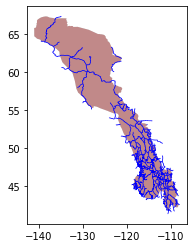

In [21]:
%%time
plot_subset(roads_subset, boundary, y2y_border=y2y.to_crs(roads_subset.crs))

## Option 3: Subset the roads dataset using track points 

Instead of providing bounding box coordinates or a region boundary for subsetting, you can also provide a csv file with animal track data. A boundary will be drawn around all the track points, with the option for either a rectangular boundary or convex hull. 

You can also specify a buffer size with this option. 

In [22]:
# Publicly available data from Mountain Caribou in British Columbia study: 
# https://www.movebank.org/cms/webapp?gwt_fragment=page=studies,path=study216040785

track_file = pmv.get_path("caribou_data.csv")

In [23]:
# Reading in the track data to plot with the results
# For just subsetting, the track data doesn't need to be read in directly 
tracks = pmv.read_track_data(track_file)

Note that the track data in this case includes almost 250,000 points, so processing is a bit slower compared with using a bounding geometry.

In [24]:
len(tracks)

249450

Here, demonstrating the option to use a convex hull around the track points, with a buffer:

In [25]:
%%time
del roads_subset, boundary, y2y   
roads_subset, boundary = pmv.subset_data(roadsfile, track_points=track_file, boundary_type='convex_hull', buffer=0.2)

CPU times: user 9.21 s, sys: 179 ms, total: 9.39 s
Wall time: 9.44 s


CPU times: user 11.5 s, sys: 111 ms, total: 11.6 s
Wall time: 11.3 s


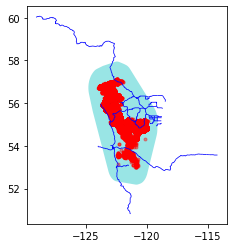

In [26]:
%%time 
plot_subset(roads_subset, boundary, track_points=tracks)